# __Travail Pratique 6 : Introduction au benchmarking de réseaux de neurones artificiels sur des données transcriptomiques de cancers__

#### <u>Importation des modules nécessaires</u>

In [1]:
import os
import umap
import h5py
import sklearn
import datetime 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.lines import Line2D
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import torch
from torch import nn
import torch.nn.functional as F

# Custom
import common.plotting
import common.dataprocessing

## __Première partie : Annexe__

### **Étape 0 : Initialisation des fonctions de visulisation des données**

In [2]:
def plot_multiple_learning_curves(nb_exp, colors, info_exp, title, err_precis) : 

    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 8))
    steps = np.arange(len(err_precis[0][0]))

    for exp in range(nb_exp) : 
        axes[0].plot(steps, err_precis[exp][0], label = f"Entraînement ({info_exp[exp]})", color = colors[exp][0])
        axes[0].plot(steps, err_precis[exp][1], label= f"Test ({info_exp[exp]})", color = colors[exp][1])
        axes[1].plot(steps, err_precis[exp][2], label = "", color = colors[exp][0])
        axes[1].plot(steps, err_precis[exp][3], label = "", color = colors[exp][1])
    
    axes[0].set_ylabel("Erreur quadratique moyenne (MSE)")
    axes[1].set_ylabel("Précision (%)")
    axes[1].set_ylim((0,105))

    axes[1].set_xlabel("Pas de gradient (époques)")
    axes[0].legend()

    axes[0].set_title('A', loc="left", weight="bold")
    axes[1].set_title('B', loc="left", weight="bold")   

    axes[0].set_title(title)

In [3]:
def plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test):
    steps = np.arange(len(trl))
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 8))
    axes[0].plot(steps, trl, label = "train")
    axes[0].plot(steps, tstl, label= "test")
    axes[1].plot(steps, trc, label = "train")
    axes[1].plot(steps, tstc, label= "test")
    axes[0].set_ylabel("MSELoss")
    axes[1].set_ylabel("Pearson Correlation")
    axes[1].set_ylim((0,100))
    axes[1].set_xlabel("Gradient step")
    axes[0].legend()
    axes[0].set_title(f"Learning curves of DNN on ML data\nN={tpm_data.shape[1]}, N(train)={X_train.shape[0]}, N(test)={X_test.shape[0]}")

def plot_ae_performance(mm, X_test):
    y_tst_out = mm(X_test)
    outs = y_tst_out.flatten().detach().numpy()
    trues = X_test.flatten().detach().numpy()
    corr =  pearsonr(outs,trues).statistic
    plt.figure(figsize = (9,7))
    plt.grid(visible =True, alpha = 0.5, linestyle = "--")
    plt.plot([0,1],[0,1], color = "blue", alpha =0.5, linestyle = "--")
    plt.hexbin(outs, trues, bins = "log")
    plt.xlabel("Predicted Expressions (normalised TPM)")
    plt.ylabel("True expressions")
    plt.colorbar(label='log10(N)')
    plt.axis("equal")
    plt.title(f"Auto-Encoder performance of reconstruction on test set.\nPearson Correlation: {round(corr,4)}")

In [6]:
# Fonction d'affichage de UMAP 
# Paramètres:
# Targets: Liste des labels présent dans le jeu de données
# Colors: Vecteur avec une liste de couleurs (doit correspondre au nombre de targets)
# X_tr_Umap et X_tst_umap: Dataframe des résultats de Umap
# Y_train, Y_test : Labels des ensembles test et train
def plotUMAP(targets, colors, X_tr_umap_df, X_tst_umap_df, Y_test, Y_train):
    plt.figure()
    for target, color in zip(targets, colors): 
        plt.scatter(X_tr_umap_df.loc[Y_train == target,0], X_tr_umap_df.loc[Y_train == target, 1], 
                    color = color, s = 10, label = target)
        plt.scatter(X_tst_umap_df.loc[Y_test == target,0], X_tst_umap_df.loc[Y_test == target, 1], 
                    s = 10, edgecolors = color, color ="white", linewidth = 0.8)

    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")

    # Légende personnaliée
    legend_elements = [Line2D([0], [0], marker = "o", markerfacecolor = "black", 
                            label = "Train", color = "w", markeredgewidth = 0.8,
                             markeredgecolor= "black", markersize=4), 
                    Line2D([0], [0], marker = "o", markerfacecolor = "w", 
                            markeredgewidth= 0.5, markeredgecolor= "black",
                            label = "Test", color = "w", markersize=4)]
    legend_supp = plt.legend(handles=legend_elements, loc = "lower left",
                        frameon = False,
                        title = "Ensemble",
                        ncol=2)
    #bbox_to_anchor=(1.25, 0.55)
    plt.legend(loc = "upper left", bbox_to_anchor=(1.04, 1.02), frameon = False,
           title = "Type de cancer")
    plt.gca().add_artist(legend_supp)

In [7]:
def plotAE_2D(targets, colors, X_tr_umap_df, X_tst_umap_df, Y_test, Y_train):
    plt.figure()
    for target, color in zip(targets, colors): 
        plt.scatter(X_tr_umap_df.loc[Y_train == target,0], X_tr_umap_df.loc[Y_train == target, 1], 
                    color = color, s = 10, label = target)
        plt.scatter(X_tst_umap_df.loc[Y_test == target,0], X_tst_umap_df.loc[Y_test == target, 1], 
                    s = 10, edgecolors = color, color ="white", linewidth = 0.8)

    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")

    # Légende personnaliée
    legend_elements = [Line2D([0], [0], marker = "o", markerfacecolor = "black", 
                            label = "Train", color = "w", markeredgewidth = 0.8,
                             markeredgecolor= "black", markersize=4), 
                    Line2D([0], [0], marker = "o", markerfacecolor = "w", 
                            markeredgewidth= 0.5, markeredgecolor= "black",
                            label = "Test", color = "w", markersize=4)]
    legend_supp = plt.legend(handles=legend_elements,
                        frameon = False,
                        title = "Ensemble")
    bbox_to_anchor=(1.25, 0.55)
    plt.legend(loc = "upper left", bbox_to_anchor=(1.04, 1.02), frameon = False,
           title = "Type de cancer")
    plt.gca().add_artist(legend_supp)

### **Étape I : Importation et visualisation des données avec UMAP**

#### <u>Importation des jeux de données</u>

In [8]:
datasets = common.dataprocessing.load_datasets()

##### <u>Visualisation de BRCA avec UMAP</u>

In [9]:
# Extraires les différentes variables du jeux de données
datasetname = "BRCA"
brca_data = datasets[datasetname].data
genes_br = datasets[datasetname].genes
labels_br = datasets[datasetname].labels
samples_br = datasets[datasetname].samples

targets_br = np.unique(labels_br)
labels_df_br = pd.DataFrame(labels_br)

print(f"Nbre d'échantillons: {len(samples_br)} -- Nbre de gènes: {len (genes_br)} -- Nbre d'étiquettes: {len(targets_br)}")

Nbre d'échantillons: 1023 -- Nbre de gènes: 11802 -- Nbre d'étiquettes: 5


In [7]:
# Séparation des données d'entraînement et de test
X_train_br, X_test_br, Y_train_br, Y_test_br = train_test_split(brca_data.T, labels_br, test_size = 0.2)

In [ ]:
mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
    n_neighbors =20, n_epochs = 1000).fit(X_train_br) 

# Transformation des données d'entraînement et de test
X_tr_umap = mapper.transform(X_train_br)
X_tst_umap = mapper.transform(X_test_br)

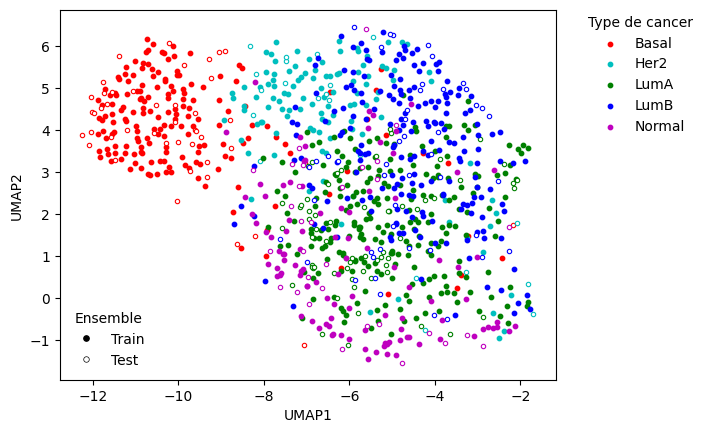

In [42]:
X_tr_umap_df = pd.DataFrame(X_tr_umap)
X_tst_umap_df = pd.DataFrame(X_tst_umap)

colors_br = ["r", "c", "g", "b", "m"]
plotUMAP(targets_br, colors_br, X_tr_umap_df, X_tst_umap_df, Y_test_br, Y_train_br)

##### <u>Visualisation de TCGA avec UMAP</u>

In [27]:
# Extraires les différentes variables du jeux de données
datasetname = "TCGA"
tcga_data = datasets[datasetname].data
genes_tc = datasets[datasetname].genes
labels_tc = datasets[datasetname].labels
samples_tc = datasets[datasetname].samples

targets_tc = np.unique(labels_tc)
labels_df_tc = pd.DataFrame(labels_tc)

labels_fixed = np.array([str(lbl).split("-")[1] for lbl in targets_tc])
tcga_abbrevs = pd.read_csv("data/../TP4/TCGA_abbrev.txt")
labels_names = []
for (i,lbl) in enumerate(np.unique(labels_fixed)):
    labels_names.append(tcga_abbrevs.loc[tcga_abbrevs["abbrv"] == lbl,"def"].values[0])

print(f"Nbre d'échantillons: {len(samples_tc)} -- Nbre de gènes: {len (genes_tc)} -- Nbre d'étiquettes: {len(targets_tc)}")

labels_fixed

Nbre d'échantillons: 10346 -- Nbre de gènes: 15165 -- Nbre d'étiquettes: 33


array(['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA',
       'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC',
       'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ',
       'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS',
       'UVM'], dtype='<U4')

In [28]:
# Séparation des données d'entraînement et de test
X_train_tc, X_test_tc, Y_train_tc, Y_test_tc = train_test_split(tcga_data.T, labels_tc, test_size = 0.2)

In [ ]:
# UMAP
mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
    n_neighbors =20, n_epochs = 1000).fit(X_train_tc) 

# Transformation des données d'entraînement et de test
X_tr_umap = mapper.transform(X_train_tc)
X_tst_umap = mapper.transform(X_test_tc)

In [32]:
X_tr_umap_df = pd.DataFrame(X_tr_umap)
X_tst_umap_df = pd.DataFrame(X_tst_umap)

colors_tc = ["r", "c", "g", "b", "m", "y", "olivedrab", "seagreen",
          "sandybrown", "silver", "darkorchid", "palevioletred",
          "hotpink", "greenyellow", "teal", "thistle", "slateblue",
          "salmon", "peachpuff", "tomato", "khaki", "cornflowerblue",
          "deeppink", "darkslateblue", "cadetblue", "aqua", "slategrey",
          "peru", "burlywood", "yellow", "goldenrod", "gainsboro", "darkred"]

plotUMAP(targets_tc, colors_tc, X_tr_umap_df, X_tst_umap_df, Y_test_tc, Y_train_tc)

##### <u>Visualisation de Leucogène - AML avec UMAP</u>

In [10]:
# Extraires les différentes variables du jeux de données
datasetname = "LAML"
laml_data = datasets[datasetname].data
genes_la = datasets[datasetname].genes
labels_la = datasets[datasetname].labels
samples_la = datasets[datasetname].samples

targets_la = np.unique(labels_la)
labels_df_la = pd.DataFrame(labels_la)

print(f"Nbre d'échantillons: {len(samples_la)} -- Nbre de gènes: {len (genes_la)} -- Nbre d'étiquettes: {len(targets_la)}")

Nbre d'échantillons: 300 -- Nbre de gènes: 19597 -- Nbre d'étiquettes: 15


In [11]:
# Séparation des données d'entraînement et de test
X_train_la, X_test_la, Y_train_la, Y_test_la = train_test_split(laml_data.T, labels_la, test_size = 0.2)

In [ ]:
# UMAP
mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
    n_neighbors =20, n_epochs = 1000).fit(X_train_la) 

# Transformation des données d'entraînement et de test
X_tr_umap = mapper.transform(X_train_la)
X_tst_umap = mapper.transform(X_test_la)

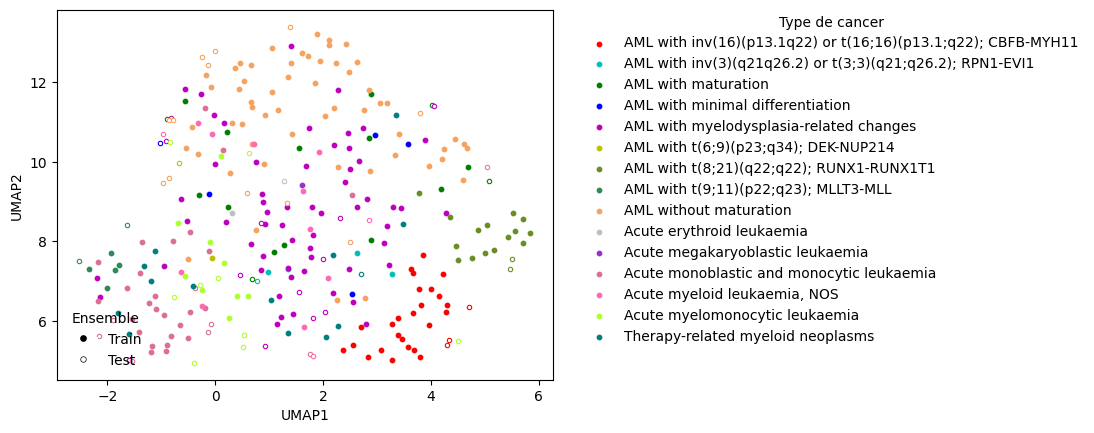

In [57]:
X_tr_umap_df = pd.DataFrame(X_tr_umap)
X_tst_umap_df = pd.DataFrame(X_tst_umap)

colors_la = ["r", "c", "g", "b", "m", "y", "olivedrab", "seagreen",
          "sandybrown", "silver", "darkorchid", "palevioletred",
          "hotpink", "greenyellow", "teal"]

plotUMAP(targets_la, colors_la, X_tr_umap_df, X_tst_umap_df, Y_test_la, Y_train_la)

##### <u>Visualisation des données TALL avec UMAP</u>

In [12]:
# Extraires les différentes variables du jeux de données
datasetname = "TALL"
tall_data = datasets[datasetname].data
genes_ta = datasets[datasetname].genes
labels_ta = datasets[datasetname].labels
samples_ta = datasets[datasetname].samples

targets_ta = np.unique(labels_ta)
labels_df_ta = pd.DataFrame(labels_ta)

print(f"Nbre d'échantillons: {len(samples_ta)} -- Nbre de gènes: {len (genes_ta)} -- Nbre d'étiquettes: {len(targets_ta)}")

Nbre d'échantillons: 264 -- Nbre de gènes: 60660 -- Nbre d'étiquettes: 10


In [13]:
# Séparation des données d'entraînement et de test
X_train_ta, X_test_ta, Y_train_ta, Y_test_ta = train_test_split(tall_data.T, labels_ta, test_size = 0.2)

In [ ]:
# UMAP
mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
    n_neighbors =20, n_epochs = 1000).fit(X_train_ta) 

# Transformation des données d'entraînement et de test
X_tr_umap = mapper.transform(X_train_ta)
X_tst_umap = mapper.transform(X_test_ta)

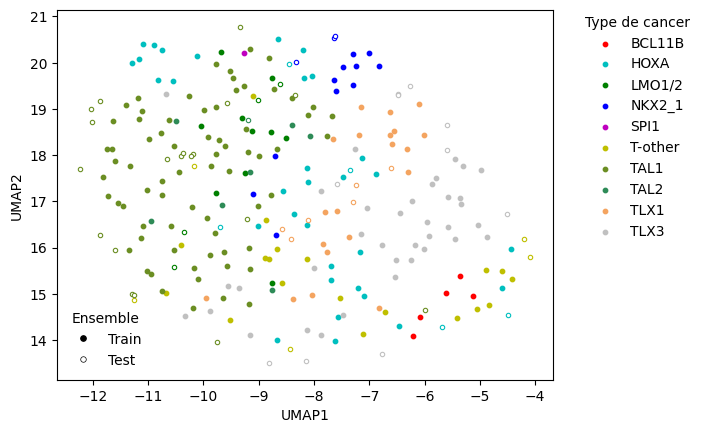

In [64]:
X_tr_umap_df = pd.DataFrame(X_tr_umap)
X_tst_umap_df = pd.DataFrame(X_tst_umap)

colors_ta = ["r", "c", "g", "b", "m", "y", "olivedrab", "seagreen",
          "sandybrown", "silver"]

plotUMAP(targets_ta, colors_ta, X_tr_umap_df, X_tst_umap_df, Y_test_ta, Y_train_ta)

### **Étape II : Création d'un réseau de neurones artificiel pour un problème de régression avec un auto-encodeur sur les données de BRCA**

#### <u>Introduction</u>

L'autoencodeur (1) est un réseau qui consiste à faire, entre autres, de la réduction de dimensionnalité avec un réseau de neurones. Cette réduction force le réseau à capter les corrélations essentielles entre les données pour les reproduire le plus fidèlement possible en sortie. Cela permet aussi de créer des modèles génératifs, c'est à dire des modèles qui peuvent générer des données qui auront les mêmes propriétés que les données d'entraînement. Le modèle a été pour la première fois abordé par Kramer en 1991 (2), mais il n'a été popularisé pour la réduction de dimensionnalité qu'en 2006 avec Hinton (3).

Références: 

(1): PyTorch [en ligne]. PyTorch documentation [cité le 17 décembre 2023]; [environ 25 écrans]. Disponible: https://pytorch.org/docs/stable/index.html 

(2): Kramer, M.A. (1991). Nonlinear principal component analysis using autoassociative neural networks. Aiche Journal, 37, 233-243.

(3): G. E. Hinton, R. R. Salakhutdinov ,Reducing the Dimensionality of Data with Neural Networks.Science313,504-507(2006).DOI:10.1126/science.1127647

#### <u>Binarisation des étiquettes</u>

In [14]:
lblbin = LabelBinarizer()
# Transformation + cast en Tensor
Y = torch.Tensor(lblbin.fit_transform(labels_br))

# Fabrication des échantillons d'entraînement et de test (cast en Tensor)
X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(brca_data.T), torch.Tensor(Y),test_size=0.2)

#### <u>Fonction d'initialisation de l'autoencodeur</u>


In [10]:
def buildModel(inSize, outSize, width, bnSize) :

    """
    Construit un autoencodeur avec 5 couches (toutes ReLU sauf pour la 
    couche centrale (espace latent)).

        Paramètres:
            inSize (int): taille des données d'entrée
            outSize (int): taille des données de sortie
            width (int): taille à travers le réseau (nombre de neurones entrant
                ou sortant d'une couche si non spécifié, couches internes)
            bnSize (int): taille de l'espace latent

        Retourne:
            model (Sequential): modèle au complet (autoencodeur)
            model[0:5] (Sequential): partie encodeur du modèle
    """

    model = nn.Sequential(
        nn.Linear(inSize, width),
        nn.ReLU(),
        nn.Linear(width, width),
        nn.ReLU(),
        nn.Linear(width, bnSize), # couche centrale
        nn.Linear(bnSize, width),
        nn.ReLU(),
        nn.Linear(width, outSize),
    )

    return model, model[0:5]


#### <u>Fonction d'entraînement de l'autoencodeur</u>

In [11]:
def trainModel(model, X_train, X_test, epochs, learningRate, weightDecay) : 

    """
    Entraîne un autoencodeur.

        Paramètres:
            model (Sequential): Modèle à entraîner
            X_train (Tensor): Données transcriptomiques d'entraînement
            X_test (Tensor): Données transcriptomiques de test
            epochs (int): Dombre d'époques d'entraînement
            adamPenalty (float): Pénalité utlisé dans l'algorithme
                d'optimisation Adam

        Retourne:
            trainLosses (list): Erreur quadratique moyenne en réel et prédit 
                de l'ensemble d'entraînement
            testLosses (list): Erreur quadratique moyenne en réel et prédit 
                de l'ensemble de test
            trainAccs (list): Corrélation de Pearson (0 à 1) entre réel et
                prédit de l'ensemble d'entraînement
            testAccs (list): Corrélation de Pearson (0 à 1) entre réel et 
                prédit de l'ensemble de test
    """

    optimizer = torch.optim.Adam(model.parameters(), lr = learningRate, weight_decay = weightDecay)
    trainLosses, testLosses, trainAccs, testAccs = [], [], [], []

    for epoch in range(epochs) :

        optimizer.zero_grad() # réinitialiser le gradient à zéro

        outTrain = model(X_train)
        outTest = model(X_test)

        # Erreur
        trainError = nn.functional.mse_loss(outTrain, X_train)
        testError = nn.functional.mse_loss(outTest, X_test)

        # Précision
        trainAcc = pearsonr(outTrain.flatten().detach().numpy(), X_train.flatten().detach().numpy()).statistic 
        testAcc = pearsonr(outTest.flatten().detach().numpy(), X_test.flatten().detach().numpy()).statistic

        # Ajout aux listes
        [trainLosses.append(float(trainError)), testLosses.append(float(testError)), trainAccs.append(float(trainAcc)), testAccs.append(float(testAcc))]

        trainError.backward()
        optimizer.step()

        # Visualisation en temps réel de l'entraînement
        if epoch % 10 == 0 : 
            print(f"Epoch {epoch} --- Train Error : {round(float(trainError), 2)} ~ Test Error : {round(float(testError), 2)} ~ Train Acc : {round(float(trainAcc), 2)} ~ Test Acc : {round(float(testAcc), 2)} ")

    return trainLosses, testLosses, trainAccs, testAccs



#### <u>Création de l'autoencodeur</u>

In [ ]:
# Modèle d'autoencodeur
ae, en = buildModel(X_train.shape[1], X_train.shape[1], 100, 2)
# Entraînement du modèle
trainMSE, testMSE, trainCorr, testCorr = trainModel(ae, X_train, X_test, 200, 0.001, 0.001)

#### <u>Visualisation de la performance</u>

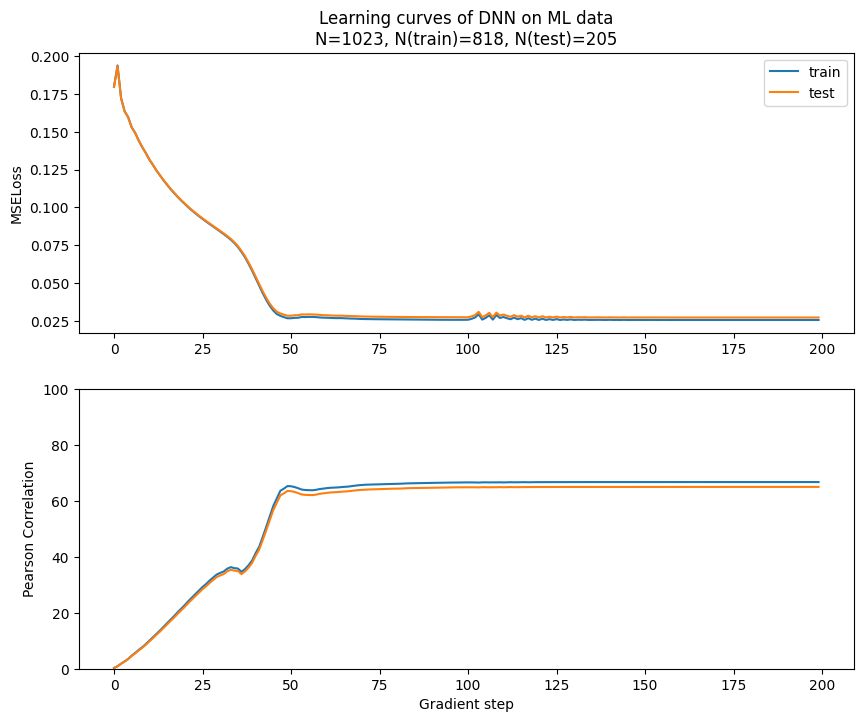

In [20]:
# Conversion de la précision en %
trainCorrPct = [corr * 100 for corr in trainCorr]
testCorrPct = [corr * 100 for corr in testCorr]

# Apprentissage
plot_learning_curves(trainMSE, testMSE, trainCorrPct, testCorrPct, brca_data, X_train, X_test)

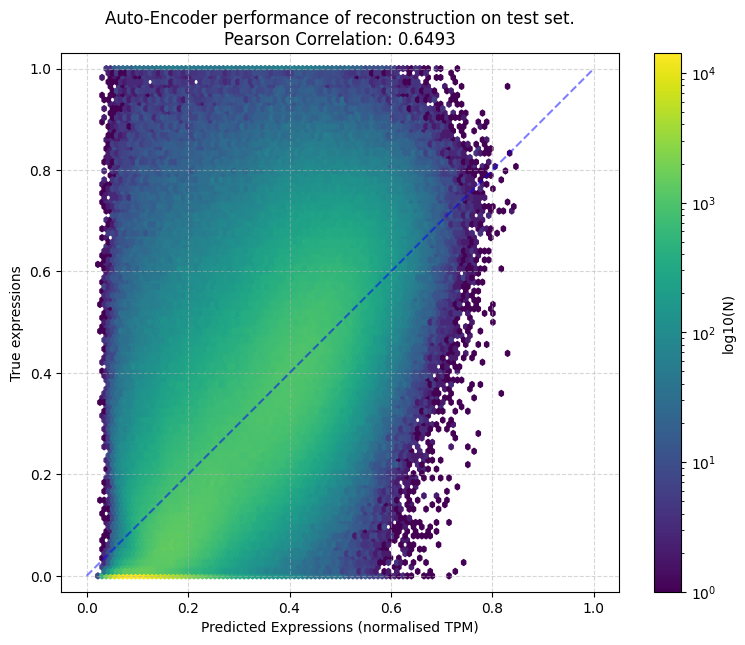

In [21]:
# Performance
plot_ae_performance(ae, X_test)

### **Étape III: Implémentation d'un Variational Auto-Encoder (VAE)**

##### <u>Introduction</u>

L'autoencodeur variationnel (1) est très semblable à l'auto-encodeur. Au lieu de devoir produire une copie exacte des données en sortie (comme l'auto-encodeur), le modèle doit fournir une distribution des données. Même s'il peut faire les mêmes choses qu'un autoencodeur traditionnel, il est surtout utilisé pour de la réduction de dimensionnalité sur des données bruitées. Ce modèle a été crée par Diederik P Kingma et Max Welling en 2013 (2).

Références: 

(1): PyTorch [en ligne]. PyTorch documentation [cité le 17 décembre 2023]; [environ 25 écrans]. Disponible: https://pytorch.org/docs/stable/index.html

(2): Kingma P.D., Weilling M. Auto-Encoding Variational Bayes. Cornell university. 2022 doi: https://doi.org/10.48550/arXiv.1312.6114

#### <u>Initialisation des classes et fonctions des auto-encodeurs variationnels</u>

In [16]:
class VariationalEncoder(nn.Module):
    def __init__(self, insize, latent_dims, width = 100):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(insize, width)
        self.linear2 = nn.Linear(width, latent_dims)
        self.linear3 = nn.Linear(width, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        #self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale # .cuda()
        self.kl = 0
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, insize, latent_dims, width = 100):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, width)
        self.linear2 = nn.Linear(width, insize)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        return self.linear2(z)
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, insize, latent_dims, width = 100):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(insize, latent_dims, width)
        self.decoder = Decoder(insize, latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [17]:
def train_Variational_Autoencodeur (vae, X_train, X_test, nepochs = 1000, printstep=100, wd = 1e-3, lr = 0.0001):
    DNN = vae
    optimizer = torch.optim.Adam(DNN.parameters(), lr = lr, weight_decay = wd)
    trainLosses, testLosses, trainAccs, testAccs = [],[],[],[]
    
    for epoch in range(nepochs):

        optimizer.zero_grad() # réinitialiser le gradient à zéro

        outTrain = DNN(X_train)
        outTest = DNN(X_test)

        # Erreur
        trainError = nn.functional.mse_loss(outTrain, X_train)
        testError = nn.functional.mse_loss(outTest, X_test)

        # Précision
        trainAcc = pearsonr(outTrain.flatten().detach().numpy(), X_train.flatten().detach().numpy()).statistic 
        testAcc = pearsonr(outTest.flatten().detach().numpy(), X_test.flatten().detach().numpy()).statistic

        trainError.backward()
        optimizer.step()

        if epoch % printstep == 0 : 
            print(f"Epoch {epoch} --- Train Error : {round(float(trainError), 2)} ~ Test Error : {round(float(testError), 2)} ~ Train Acc : {round(float(trainAcc), 2)} ~ Test Acc : {round(float(testAcc), 2)} ")

        [trainLosses.append(float(trainError)), testLosses.append(float(testError)), trainAccs.append(float(trainAcc)), testAccs.append(float(testAcc))]
    return trainLosses, testLosses, trainAccs, testAccs

#### <u>Utilisation des données initialisées précedemment</u>

#### <u>Création du modèle</u>

In [ ]:
vae = VariationalAutoencoder(X_train.shape[1], 2, 150)
vae(X_train)
tr_losses, tst_losses, tr_accs, tst_accs = train_Variational_Autoencodeur(vae, X_train, X_test)

#### <u>Visualisation de l'apprentissage et de la performance</u>

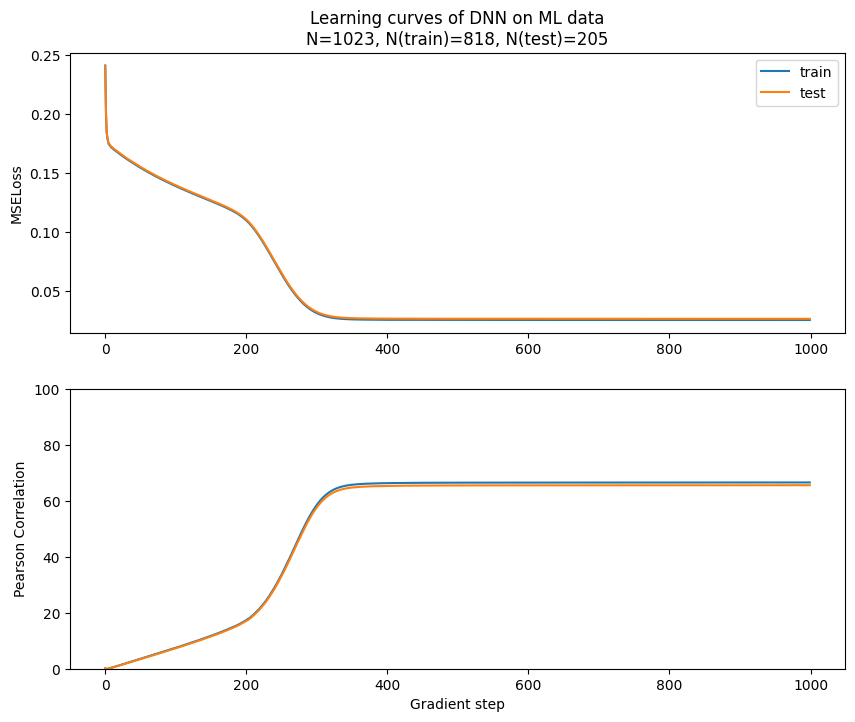

In [28]:
plot_learning_curves(tr_losses, tst_losses, tr_accs, tst_accs, brca_data, X_train, X_test)

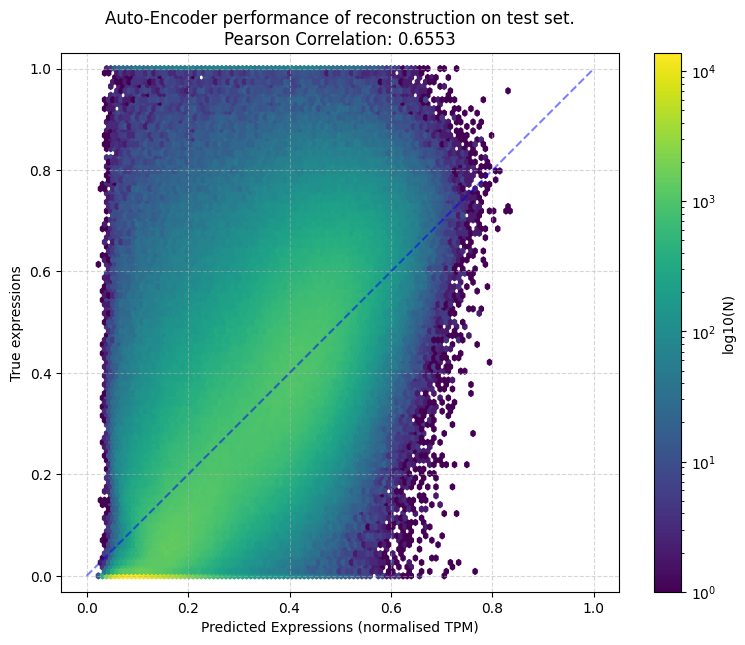

In [26]:
# Visualisation avec un diagramme de densité
common.plotting.plot_ae_performance(ae, X_test) # À modifier 

### **Étape IV : UMAP supervisé sur les données de BRCA**

##### <u>Introduction</u>

L'UMAP supervisé (1) est un entraînement de UMAP où les étiquettes de prédiction sont précisés. L'apprentissage supervisé permet de faciliter le processus de réduction de dimensionnalité de UMAP. En effet, cela permet au modèle d'associer une distance avec chaque classe, permettant ainsi de mieux séparer les données, améliorant ainsi la visualisation. Le modèle a été conçu par Leland McInnes, John Healy, et James Melville en 2020 (2).

Références: 

(1): UMAP [En ligne]. 2018. UMAP for Supervised Dimension Reduction and Metric Learning [cité le 17 décembre 2023]; [environ 20 écrans] Disponible: https://umap-learn.readthedocs.io/en/latest/supervised.html#training-with-labels-and-embedding-unlabelled-test-data-metric-learning-with-umap 

(2): McInnes L., Healy J., Melville J. UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. 2020; doi: https://doi.org/10.48550/arXiv.1802.03426

In [ ]:
lblenc = LabelEncoder()
lblenc.fit(labels_br)
Y = lblenc.transform(labels_br)
X_train, X_test, Y_train, Y_test = train_test_split(brca_data.T, Y, test_size = 0.2)
mapper = umap.UMAP(verbose = 1, n_components = 2, min_dist=1., 
    n_neighbors =5, n_epochs = 1000).fit(X_train,  y = Y_train)

In [ ]:
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)

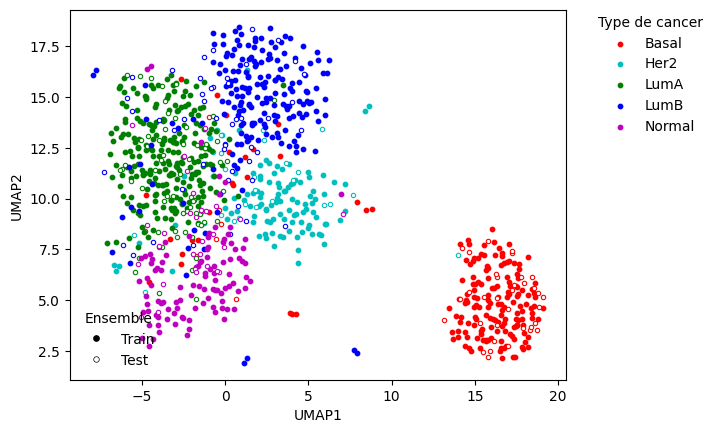

In [15]:
X_tr_umap_df = pd.DataFrame(X_tr_umap)
X_tst_umap_df = pd.DataFrame(X_tst_umap)

colors_br = ["r", "c", "g", "b", "m"]
plotUMAP(targets_br, colors_br, X_tr_umap_df, X_tst_umap_df, lblenc.inverse_transform(Y_test), lblenc.inverse_transform(Y_train))

## **Deuxième partie : Projet**

### **Hyper-paramétrisation et comparaison des performances des auto-encodeurs et des VAE pour la régression sur de vraies données transcriptomiques des cancers**

#### A. <u>Fixation de la taille des couches internes, de la régularisation L2 (wd, weight decay) et du taux d'apprentissage (lr, learning rate).</u> 

<u>Méthodologie</u>

Avant d'observer l'effet du bottleneck, la taille des couches internes, la régularisation L2 (weight decay), et le taux d'apprentissage des deux modèles (autoencodeur, et autoencodeur variationnel) ont été optimisé. Pour ce faire, les deux modèles sont entraînés avec le jeux de données TCGA, avec le même ensemble entraînement (80% des profils transcriptomiques) et test (20% des profils transcriptomiques). Chacuns des hyper-paramètres sont testés indépendamment, avec plusieurs valeurs différentes. 500 itérations d'entraînement sont utilisés, afin de pouvoir bien observer la convergence des deux modèles. Une fois l'entraînement terminé, les courbes d'apprentissage sont générés. La valeur finale de l'hyper-paramètre est choisie selon la performance de l'apprentissage du modèle.

<u>Auto-encodeur (AE)</u>

- Initialisation de l'AE avec **buildModel**
- Entraînement de l'AE avec **trainModel**

In [12]:
# Génération des ensembles tests et train 
lblbin = LabelBinarizer()
# Transformation + cast en Tensor
Y = torch.Tensor(lblbin.fit_transform(labels_br))

# Fabrication des échantillons d'entraînement et de test (cast en Tensor)
X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(brca_data.T), torch.Tensor(Y),test_size=0.2)

In [13]:
insize = X_train.shape[1]
outsize = X_train.shape[1]

1. Taille des couches internes

In [ ]:
# Variation dans la taille des couches internes

tests_couche_interne = []

for i in range(1,5) :
    ae_ci, en_ci = buildModel(insize, outsize, i*100, 2)
    trainMSE_ci, testMSE_ci, trainCorr_ci, testCorr_ci = trainModel(ae_ci, X_train, X_test, 500, 0.001, 0.001)
    tests_couche_interne.append([trainMSE_ci, testMSE_ci, [i * 100 for i in trainCorr_ci], [i * 100 for i in testCorr_ci]])

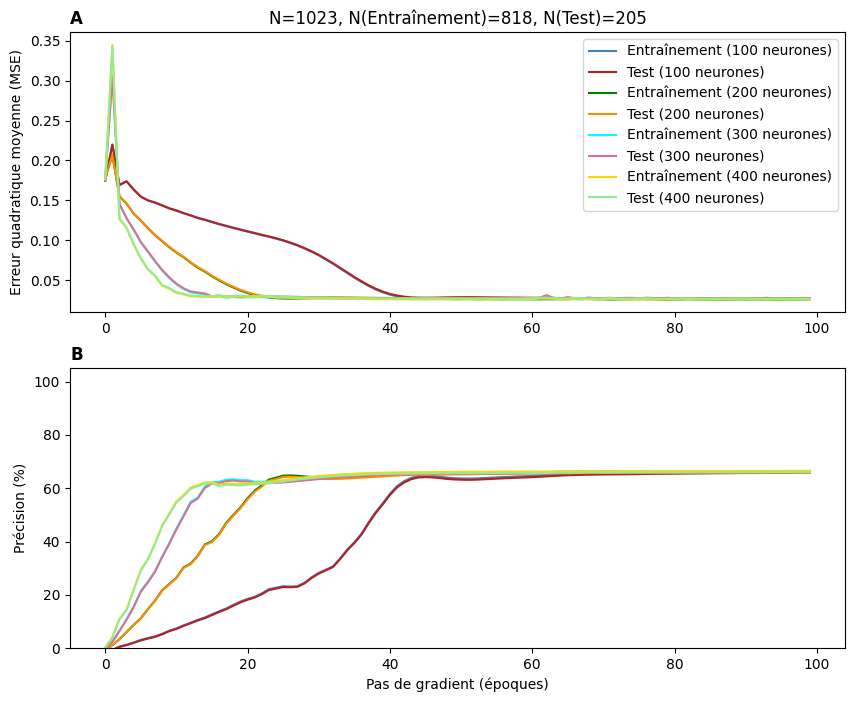

In [26]:
# Visualisation des courbes d'apprentissage
colors = [["steelblue", "firebrick"], ["green", "darkorange"], ["aqua", "palevioletred"], ["gold", "lightgreen"]]
info_exp = ["100 neurones", "200 neurones", "300 neurones", "400 neurones"]
title = f"N={brca_data.shape[1]}, N(Entraînement)={X_train.shape[0]}, N(Test)={X_test.shape[0]}"
plot_multiple_learning_curves(4, colors, info_exp, 
                              title,
                              tests_couche_interne)

# Les couches internes 

In [ ]:
tests_couche_interne = []

for i in range(5,8) :
    ae_ci, en_ci = buildModel(insize, outsize, i*100, 2)
    trainMSE_ci, testMSE_ci, trainCorr_ci, testCorr_ci = trainModel(ae_ci, X_train, X_test, 500, 0.001, 0.001)
    tests_couche_interne.append([trainMSE_ci, testMSE_ci, [i * 100 for i in trainCorr_ci], [i * 100 for i in testCorr_ci]])

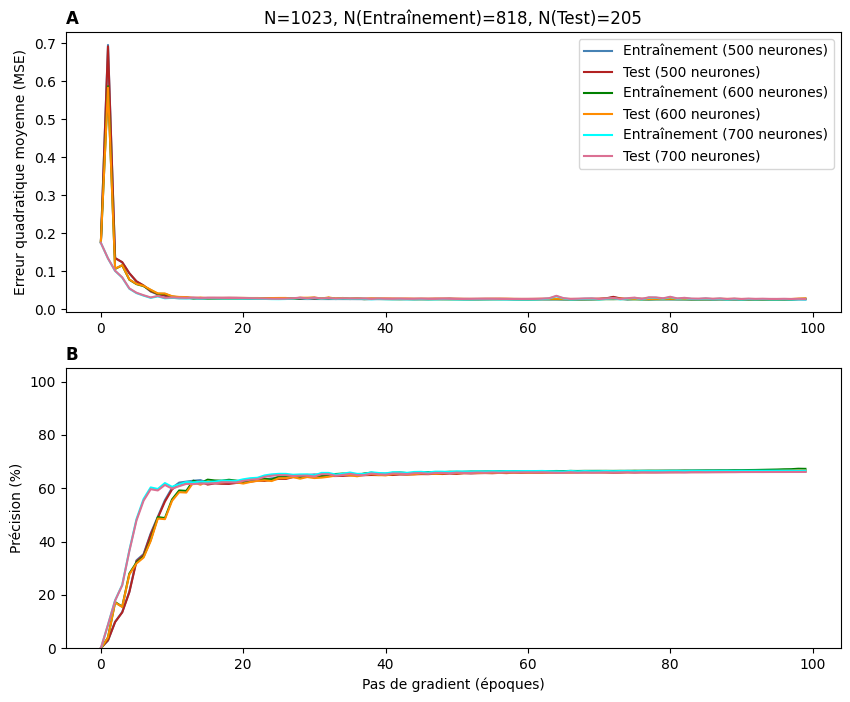

In [28]:
info_exp = ["500 neurones", "600 neurones", "700 neurones", "800 neurones"]
plot_multiple_learning_curves(3, colors, info_exp, 
                              title,
                              tests_couche_interne)

<u>Observation et conclusion</u>

- Après 400 neurones, les courbes sont semblabes et deviennent moins lisses.
- La taille de 400 neurones en couche interne est conservée pour le futur.

2. Régularisation L2

In [ ]:
# Variation dans la régularisation L2 (wd, weight decay)
tests_wd = []
wd_tries = [0.0001, 0.001, 0.01]
for wd in wd_tries: 
    ae_wd, en_wd = buildModel(insize, outsize, 400, 2)
    trainMSE_wd, testMSE_wd, trainCorr_wd, testCorr_wd = trainModel(ae_wd, X_train, X_test, 500, 0.001, wd)
    tests_wd.append([trainMSE_wd, testMSE_wd, [i*100 for i in trainCorr_wd], [i*100 for i in testCorr_wd]])

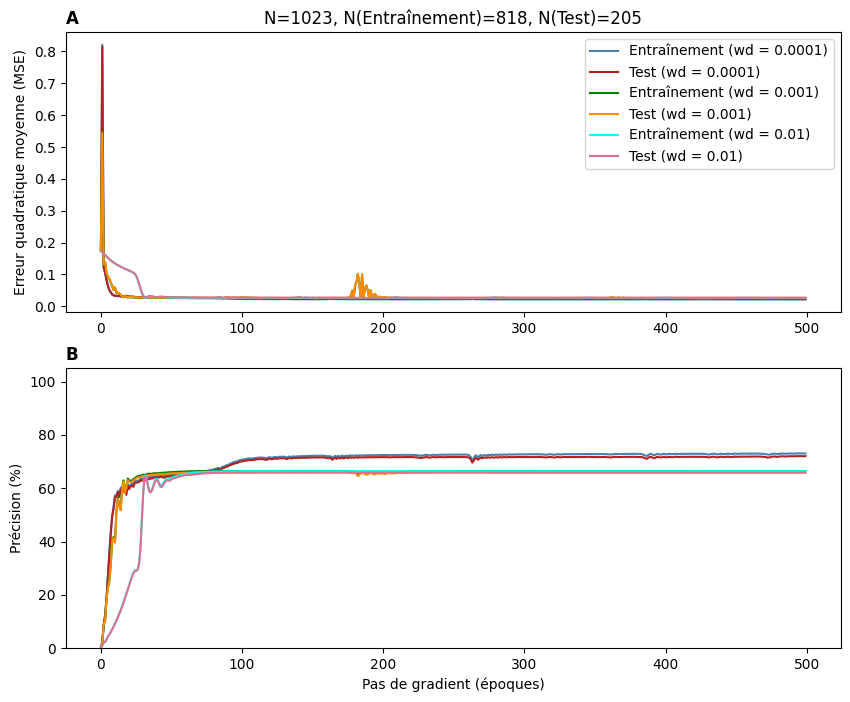

In [36]:
# Visualisation des courbes d'apprentissage

colors = [["steelblue", "firebrick"], ["green", "darkorange"], ["aqua", "palevioletred"], ["gold", "lightgreen"]]
info_exp = ["wd = 0.0001", "wd = 0.001", "wd = 0.01"]
title = f"N={brca_data.shape[1]}, N(Entraînement)={X_train.shape[0]}, N(Test)={X_test.shape[0]}"
plot_multiple_learning_curves(3, colors, info_exp, 
                              title,
                              tests_wd)

<u> Observations et conclusions </u>

- Les courbes d'apprentissage se comportent de manière assez similaires entre les différentes régularisations L2
- La courbe avec la régularisation de 0.0001 semble converger vers une précision supérieure par rapport aux autres valeurs testés
- Une régularisation de 0.0001 est donc maintenue

3. Learning Rate

In [ ]:
# Variations dans le taux d'apprentissage (lr, learning rate)

tests_lr = []

for lr in [0.0001, 0.001, 0.01] :
    ae_lr, en_lr = buildModel(insize, outsize, 400, 2)
    trainMSE_lr, testMSE_lr, trainCorr_lr, testCorr_lr = trainModel(ae_lr, X_train, X_test, 500, lr, 0.0001)
    tests_lr.append([trainMSE_lr, testMSE_lr, [i * 100 for i in trainCorr_lr], [i * 100 for i in testCorr_lr]])


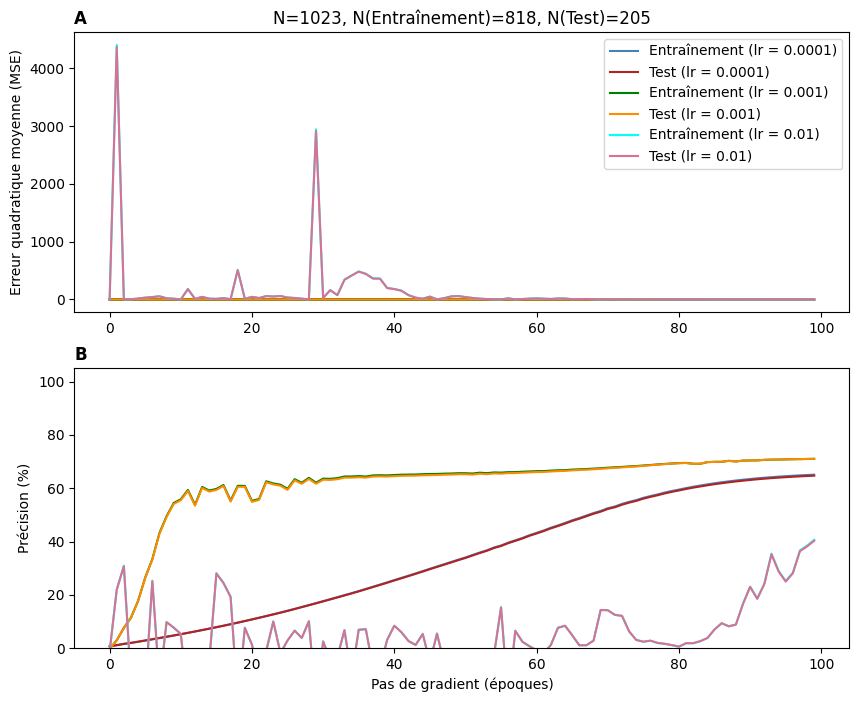

In [21]:
colors = [["steelblue", "firebrick"], ["green", "darkorange"], ["aqua", "palevioletred"], ["gold", "lightgreen"]]
info_exp = ["lr = 0.0001", "lr = 0.001", "lr = 0.01"]
title = f"N={brca_data.shape[1]}, N(Entraînement)={X_train.shape[0]}, N(Test)={X_test.shape[0]}"
plot_multiple_learning_curves(3, colors, info_exp, 
                              title,
                              tests_lr)

<u> Observations et conclusions </u>

- Beaucoup de resessemblance entre les courbes dans le graphique d'erreur, mais beaucoup de différences sont observées dans le graphique de précision
- Dans le graphique de précision, la courbe avec un learning rate de 0.001 converge le plus vite. Le learning rate de 0.01 est très irrégulier, mais semble converger aussi.
- Le learning rate de 0.001 qui semble obtenir la meileur précision, tout en ayant une convergence plus rapide. C'est donc cette valeur qui est retenue

Auto-encodeur variationnel (VAE)

Détermination des paramètres optimaux pour le VAE

1. Taille des couches internes

In [ ]:
tests_couche_interne = []

for i in range(1,5) :
    vae = VariationalAutoencoder(insize, 2, i*100)
    trainMSE_ci, testMSE_ci, trainCorr_ci, testCorr_ci = train_Variational_Autoencodeur(vae, X_train, X_test, 500, 10, 0.001, 0.0001)
    tests_couche_interne.append([trainMSE_ci, testMSE_ci, [i * 100 for i in trainCorr_ci], [i * 100 for i in testCorr_ci]])

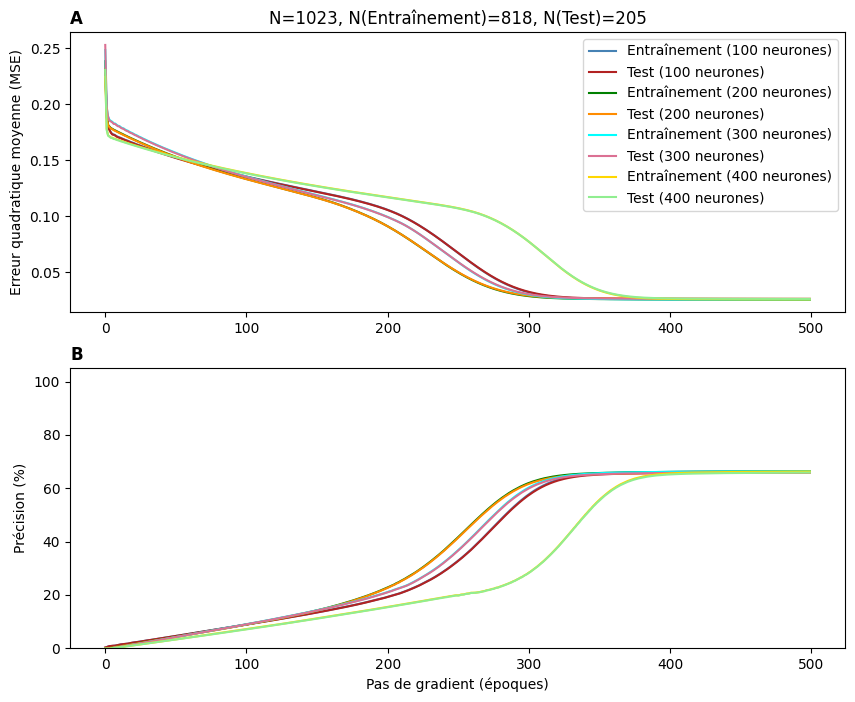

In [23]:
colors = [["steelblue", "firebrick"], ["green", "darkorange"], ["aqua", "palevioletred"], ["gold", "lightgreen"]]
info_exp = ["100 neurones", "200 neurones", "300 neurones", "400 neurones"]
title = f"N={brca_data.shape[1]}, N(Entraînement)={X_train.shape[0]}, N(Test)={X_test.shape[0]}"
plot_multiple_learning_curves(4, colors, info_exp, 
                              title,
                              tests_couche_interne)

<u>Observations et conclusion</u>

- Peu importe le nombre de neurones utilisé, la convergence reste vers la même valeur
- La courbe de 200 neurones semble atteindre plus vite le point de convergence que les autres courbes
- Des couches de 200 neurones sont donc maintenues

2. Régularisation L2

In [ ]:
tests_wd = []
wd_tries = [0.0001, 0.001, 0.01]
for wd in wd_tries: 
    vae = VariationalAutoencoder(insize, 2, 200)
    trainMSE_wd, testMSE_wd, trainCorr_wd, testCorr_wd = train_Variational_Autoencodeur(vae, X_train, X_test, 500, 100, wd, 0.0001)
    tests_wd.append([trainMSE_wd, testMSE_wd, [i*100 for i in trainCorr_wd], [i*100 for i in testCorr_wd]])

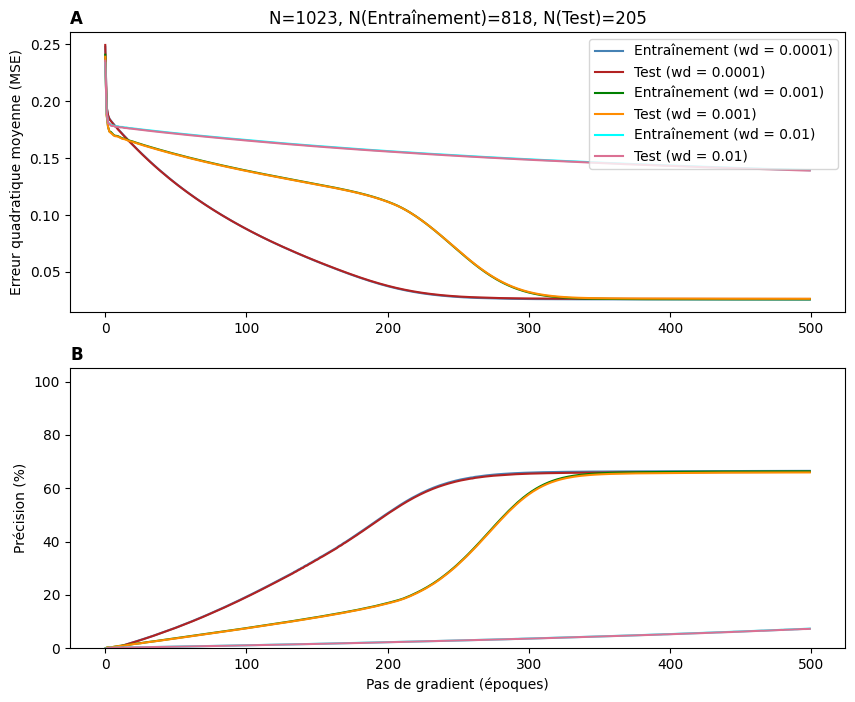

In [26]:

colors = [["steelblue", "firebrick"], ["green", "darkorange"], ["aqua", "palevioletred"], ["gold", "lightgreen"]]
info_exp = ["wd = 0.0001", "wd = 0.001", "wd = 0.01"]
title = f"N={brca_data.shape[1]}, N(Entraînement)={X_train.shape[0]}, N(Test)={X_test.shape[0]}"
plot_multiple_learning_curves(3, colors, info_exp, 
                              title,
                              tests_wd)

<u> Observations et conclusions </u>

- Les trois valeurs de régularisation ont un impact important sur l'apprentissage. Ils ont chancun leur courbe distincte. 
- La régularisation de 0.0001 et 0.001 convergent vers les mêmes valeurs, mais pas 0.01, qui ne semble pas encore converger. 
- Comme la régularisation de 0.0001 est la courbe qui semble atteindre le point de convergence le plus vite, c'est cette valeur qui est sélectionnée

3. Learning Rate

In [ ]:
tests_lr = []

for lr in [0.0001, 0.001, 0.01] :
    vae = VariationalAutoencoder(insize, 2, 200)
    trainMSE_lr, testMSE_lr, trainCorr_lr, testCorr_lr = train_Variational_Autoencodeur(vae, X_train, X_test, 500, 100, 0.0001, lr)
    tests_lr.append([trainMSE_lr, testMSE_lr, [i * 100 for i in trainCorr_lr], [i * 100 for i in testCorr_lr]])

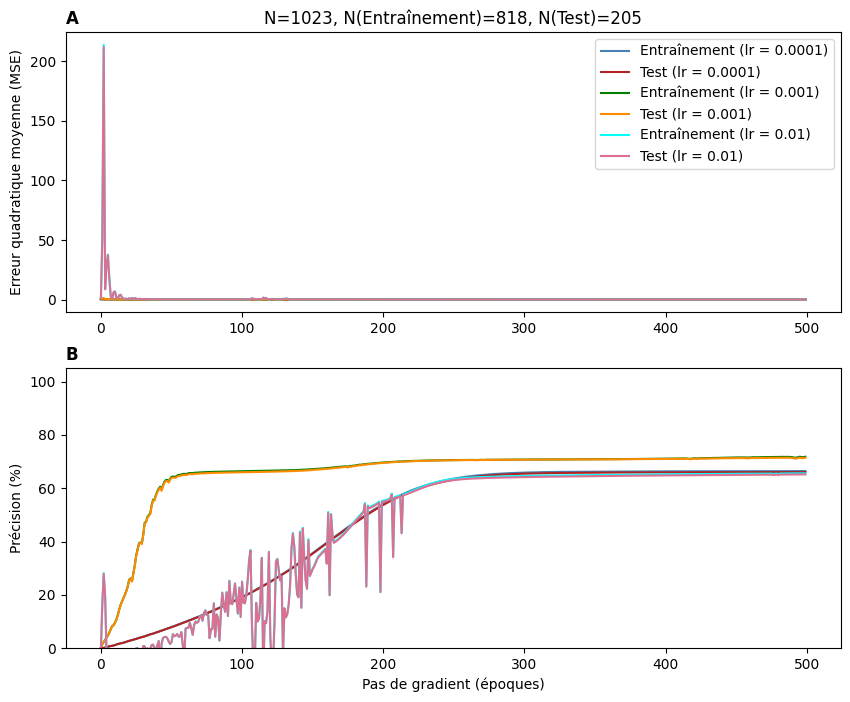

In [28]:
colors = [["steelblue", "firebrick"], ["green", "darkorange"], ["aqua", "palevioletred"], ["gold", "lightgreen"]]
info_exp = ["lr = 0.0001", "lr = 0.001", "lr = 0.01"]
title = f"N={brca_data.shape[1]}, N(Entraînement)={X_train.shape[0]}, N(Test)={X_test.shape[0]}"
plot_multiple_learning_curves(3, colors, info_exp, 
                              title,
                              tests_lr)

<u> Observations et conclusions </u>

- Même comportement que pour l'auto-encodeur
- Le learning rate de 0.001 est gardé pour sa précision supérieure et sa convergence plus rapide

#### B. <u>Expérience sur la variation de la taille de l'espace latent dans le cas d'un AE ou VAE.</u>

Hyper-paramètres fixés AE: 
- Couches internes = 400 neurones
- Weight Decay = 0.0001
- Learning Rate = 0.001

Hyper paramètres fixés AEV:
- Couches internes = 200 neurones
- Weight Decay = 0.0001
- Learning Rate = 0.001

Tailles testées : [1,2,3,5,10,15,20,25,30,50,75,100,125,150,200,300]

1. Autoencodeur (AE)

In [ ]:
# Initialosation des arrays pour la figure finale
bn_size_test = []
bn_precision = []
bn_best_model = []

# Visualisation de l'effet bottleneck -- Partie 1
tests_bn = []
bn_try = [1,2,3,5,10,15]

for bn_size in bn_try : # Pas sure de on prend combien pour le nombre d'itération, mais je pense 500 c'est correct
    ae_bn, en_bn = buildModel(insize, outsize, 400, bn_size)
    trainMSE_bn, testMSE_bn, trainCorr_bn, testCorr_bn = trainModel(ae_bn, X_train, X_test, 500, 0.001, 0.0001)
    tests_bn.append([trainMSE_bn, testMSE_bn, [i * 100 for i in trainCorr_bn], [i * 100 for i in testCorr_bn]])
    
    bn_precision.append(testCorr_bn[-1]*100)
    bn_size_test.append(bn_size)


In [14]:
print(bn_size_test)
print(bn_precision)

[1, 2, 3, 5, 10, 15]
[68.6054872100266, 72.02820410183215, 74.54092662623715, 77.44160590952863, 77.45638390296237, 77.36480166948603]


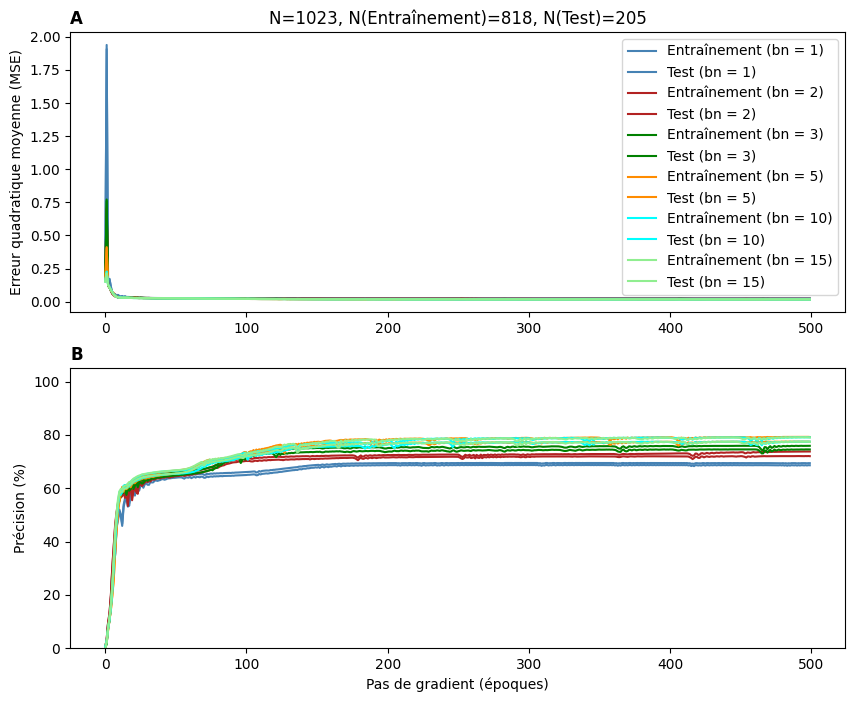

In [15]:
colors = [["steelblue", "steelblue"], 
          ["firebrick", "firebrick"], 
          ["green", "green"],
          ["darkorange", "darkorange"],
          ["aqua", "aqua"], 
          ["lightgreen", "lightgreen"]]

info_exp = ["bn = 1", "bn = 2", "bn = 3", "bn = 5", "bn = 10", "bn = 15"]
title = f"N={brca_data.shape[1]}, N(Entraînement)={X_train.shape[0]}, N(Test)={X_test.shape[0]}"
plot_multiple_learning_curves(6, colors, info_exp, 
                              title,
                              tests_bn)

In [ ]:
tests_bn = []
bn_try = [20,25,30,50,75,100]
for bn_size in bn_try : # Pas sure de on prend combien pour le nombre d'itération, mais je pense 500 c'est correct
    ae_bn, en_bn = buildModel(insize, outsize, 400, bn_size)
    trainMSE_bn, testMSE_bn, trainCorr_bn, testCorr_bn = trainModel(ae_bn, X_train, X_test, 500, 0.001, 0.0001)
    tests_bn.append([trainMSE_bn, testMSE_bn, [i * 100 for i in trainCorr_bn], [i * 100 for i in testCorr_bn]])
    
    bn_precision.append(testCorr_bn[-1]*100)
    bn_size_test.append(bn_size)

In [18]:
print(bn_size_test)
print(bn_precision)

[1, 2, 3, 5, 10, 15, 20, 25, 20, 25, 30, 50, 75, 100]
[68.6054872100266, 72.02820410183215, 74.54092662623715, 77.44160590952863, 77.45638390296237, 77.36480166948603, 77.14365640136069, 77.42502081705557, 77.26058406448585, 77.38851949653022, 77.28559663332129, 77.25934660454523, 76.17676393258363, 74.71032995449252]


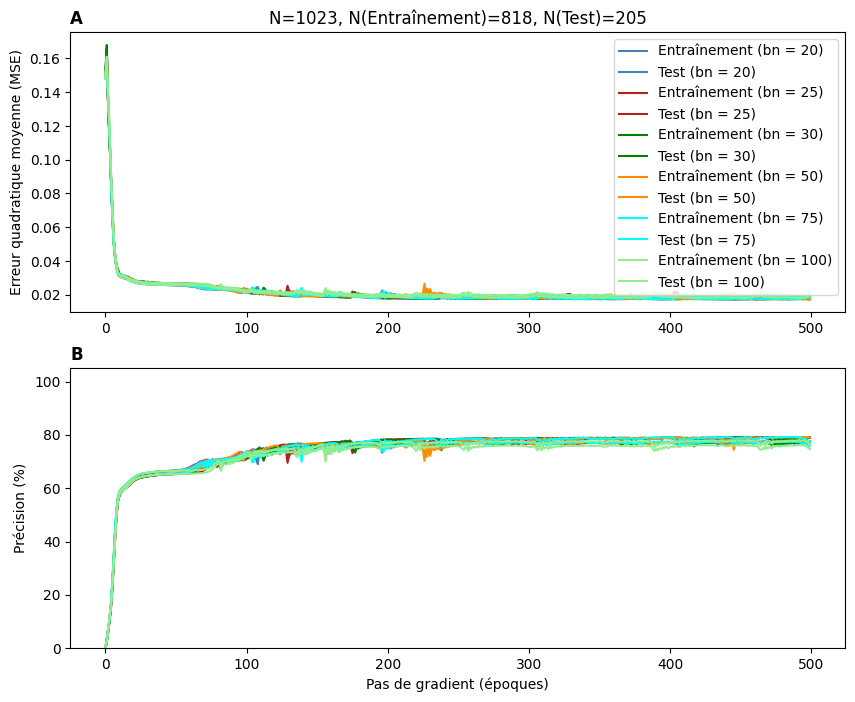

In [19]:
colors = [["steelblue", "steelblue"], 
          ["firebrick", "firebrick"], 
          ["green", "green"],
          ["darkorange", "darkorange"],
          ["aqua", "aqua"], 
          ["lightgreen", "lightgreen"]]

info_exp = ["bn = 20", "bn = 25", "bn = 30", "bn = 50", "bn = 75", "bn = 100"]
title = f"N={brca_data.shape[1]}, N(Entraînement)={X_train.shape[0]}, N(Test)={X_test.shape[0]}"
plot_multiple_learning_curves(6, colors, info_exp, 
                              title,
                              tests_bn)

In [ ]:
tests_bn = []
bn_try = [100,125,150,200,300]
for bn_size in bn_try : # Pas sure de on prend combien pour le nombre d'itération, mais je pense 500 c'est correct
    ae_bn, en_bn = buildModel(insize, outsize, 400, bn_size)
    trainMSE_bn, testMSE_bn, trainCorr_bn, testCorr_bn = trainModel(ae_bn, X_train, X_test, 500, 0.001, 0.0001)
    tests_bn.append([trainMSE_bn, testMSE_bn, [i * 100 for i in trainCorr_bn], [i * 100 for i in testCorr_bn]])
    
    bn_precision.append(testCorr_bn[-1]*100)
    bn_size_test.append(bn_size)

In [21]:
print(bn_size_test)
print(bn_precision)

[1, 2, 3, 5, 10, 15, 20, 25, 20, 25, 30, 50, 75, 100, 100, 125, 150, 200, 300]
[68.6054872100266, 72.02820410183215, 74.54092662623715, 77.44160590952863, 77.45638390296237, 77.36480166948603, 77.14365640136069, 77.42502081705557, 77.26058406448585, 77.38851949653022, 77.28559663332129, 77.25934660454523, 76.17676393258363, 74.71032995449252, 77.2319237975688, 77.39077565885039, 77.43728367414317, 75.70047511738662, 75.68300615875626]


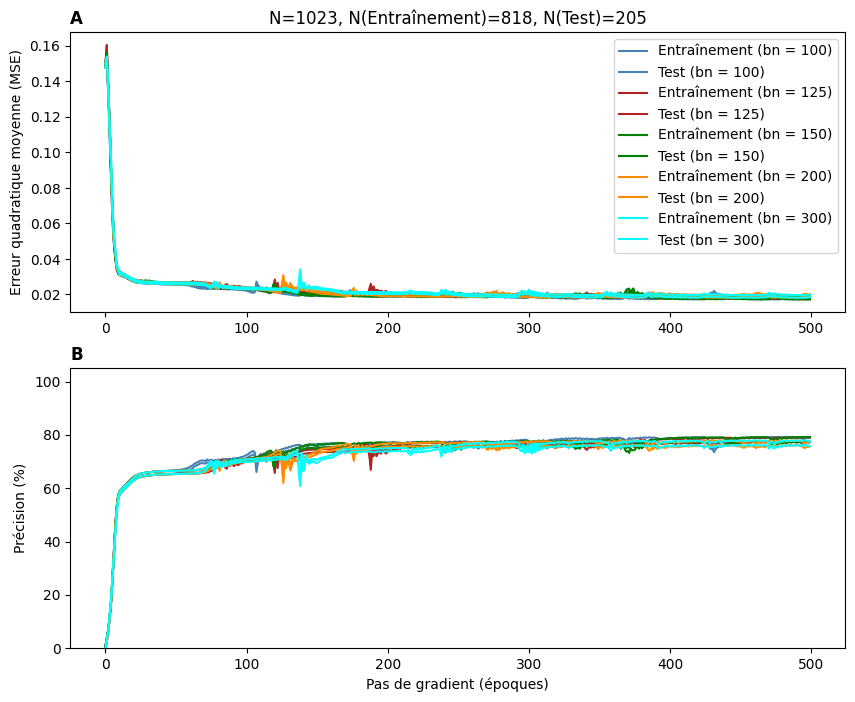

In [22]:
colors = [["steelblue", "steelblue"], 
          ["firebrick", "firebrick"], 
          ["green", "green"],
          ["darkorange", "darkorange"], 
          ["aqua", "aqua"], 
          ["lightgreen", "lightgreen"]]

info_exp = ["bn = 100", "bn = 125", "bn = 150", "bn = 200", "bn = 300"]
title = f"N={brca_data.shape[1]}, N(Entraînement)={X_train.shape[0]}, N(Test)={X_test.shape[0]}"
plot_multiple_learning_curves(5, colors, info_exp, 
                              title,
                              tests_bn)

Conctruction des figures finales:

In [31]:
bn_size_test = [1, 2, 3, 5, 10, 15, 20, 25, 30, 50, 75, 100, 125, 150, 200, 300]
bn_precision = [68.6054872100266, 72.02820410183215, 74.54092662623715, 77.44160590952863, 77.45638390296237, 77.36480166948603, 77.26058406448585, 77.38851949653022, 77.28559663332129, 77.25934660454523, 76.17676393258363, 77.2319237975688, 77.39077565885039, 77.43728367414317, 75.70047511738662, 75.68300615875626]

In [28]:

bn_precision[6:10]

[77.14365640136069, 77.42502081705557, 77.26058406448585, 77.38851949653022]

In [ ]:
# make dictionary
bn_ae_to_plot = {}
for i in range(len(bn_size_test)) : bn_ae_to_plot[str(bn_size_test[i])] = np.round(bn_precision[i],1)

[Text(-45, 0, '68.6%'),
 Text(-45, 0, '72.0%'),
 Text(-45, 0, '74.5%'),
 Text(-45, 0, '77.4%'),
 Text(-45, 0, '77.5%'),
 Text(-45, 0, '77.4%'),
 Text(-45, 0, '77.3%'),
 Text(-45, 0, '77.4%'),
 Text(-45, 0, '77.3%'),
 Text(-45, 0, '77.3%'),
 Text(-45, 0, '76.2%'),
 Text(-45, 0, '77.2%'),
 Text(-45, 0, '77.4%'),
 Text(-45, 0, '77.4%'),
 Text(-45, 0, '75.7%'),
 Text(-45, 0, '75.7%')]

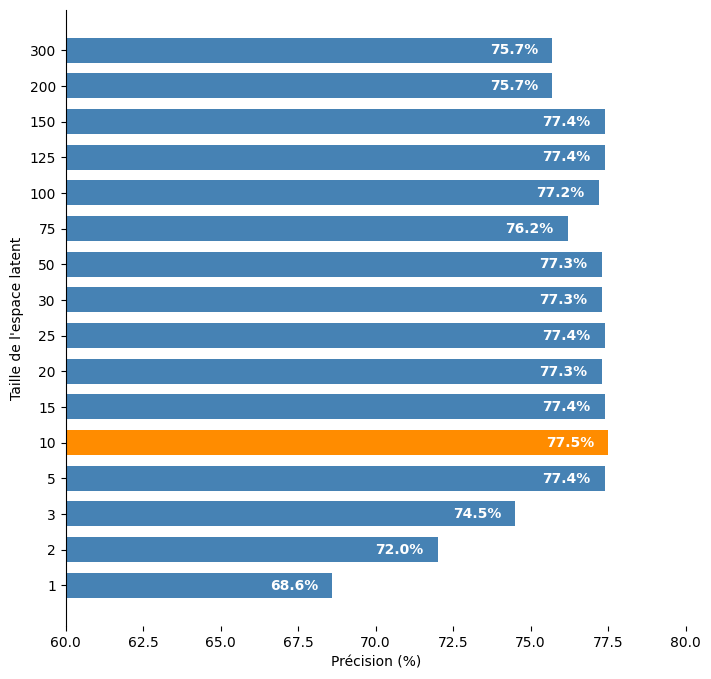

In [82]:
df = pd.DataFrame(bn_ae_to_plot.items(), columns=["bn_size", "precision"])
highest_precision = max(np.round(bn_precision,1))
df["colors"] = df["precision"].apply(lambda x: "darkorange" if x == highest_precision else "steelblue")

fig, ax = plt.subplots(figsize=(8,8))
bars = plt.barh(df["bn_size"], df["precision"], height=0.7, color=df["colors"])

ax.spines[["right", "top", "bottom"]].set_visible(False)
plt.ylabel("Taille de l'espace latent", fontsize=10)
plt.xlabel("Précision (%)", fontsize=10)
plt.xlim(60,80)

ax.bar_label(bars, padding = -45, color = "white", fontsize=10, label_type="edge", fmt="%.1f%%", fontweight="bold")


Epoch 0 --- Train Error : 0.15 ~ Test Error : 0.15 ~ Train Acc : 0.01 ~ Test Acc : 0.01 
Epoch 10 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.59 ~ Test Acc : 0.59 
Epoch 20 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.63 ~ Test Acc : 0.63 
Epoch 30 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.65 ~ Test Acc : 0.65 
Epoch 40 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.66 
Epoch 50 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.66 
Epoch 60 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.67 ~ Test Acc : 0.67 
Epoch 70 --- Train Error : 0.02 ~ Test Error : 0.02 ~ Train Acc : 0.69 ~ Test Acc : 0.7 
Epoch 80 --- Train Error : 0.02 ~ Test Error : 0.02 ~ Train Acc : 0.71 ~ Test Acc : 0.71 
Epoch 90 --- Train Error : 0.02 ~ Test Error : 0.02 ~ Train Acc : 0.71 ~ Test Acc : 0.71 
Epoch 100 --- Train Error : 0.02 ~ Test Error : 0.02 ~ Train Acc : 0.71 ~ Test Acc : 0.71 
Epoch 110 -

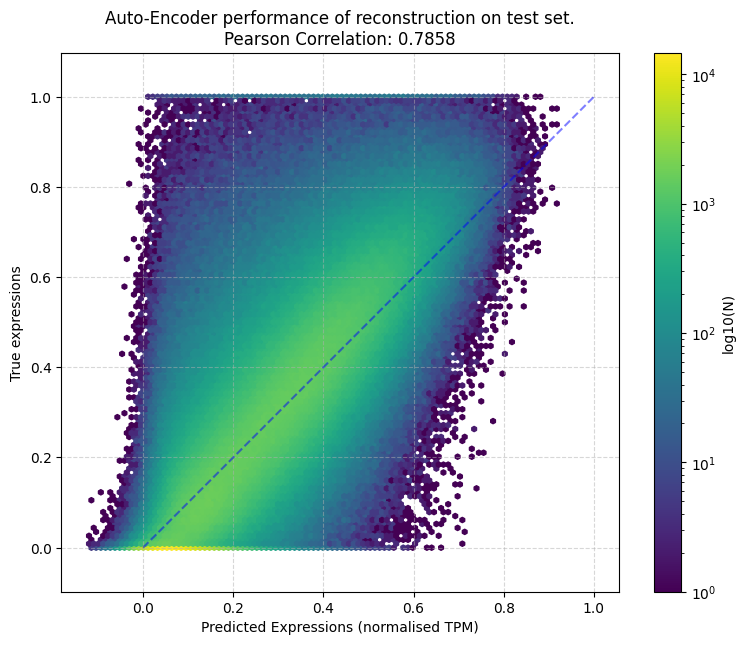

In [14]:
# Affichage de la matrice de confusion du bottleneck le plus performant
ae_bn, en_bn = buildModel(insize, outsize, 400, 10)
trainMSE_bn, testMSE_bn, trainCorr_bn, testCorr_bn = trainModel(ae_bn, X_train, X_test, 500, 0.001, 0.0001)

plot_ae_performance(ae_bn, X_test)

2. Autoencodeur variationel (VAE)

In [ ]:
tests_bn_vae = []
bn_precision_vae = []
bn_size_test_vae = []

bn_try = [1,2,3,5,10,15]
for bn_size in bn_try :
    vae = VariationalAutoencoder(insize, bn_size, 200)
    trainMSE_bn_vae, testMSE_bn_vae, trainCorr_bn_vae, testCorr_bn_vae = train_Variational_Autoencodeur(vae, X_train, X_test, 500, 100, 0.0001, 0.001)
    tests_bn_vae.append([trainMSE_bn_vae, testMSE_bn_vae, [i * 100 for i in trainCorr_bn_vae], [i * 100 for i in testCorr_bn_vae]])

    bn_precision_vae.append(testCorr_bn_vae[-1]*100)
    bn_size_test_vae.append(bn_size)

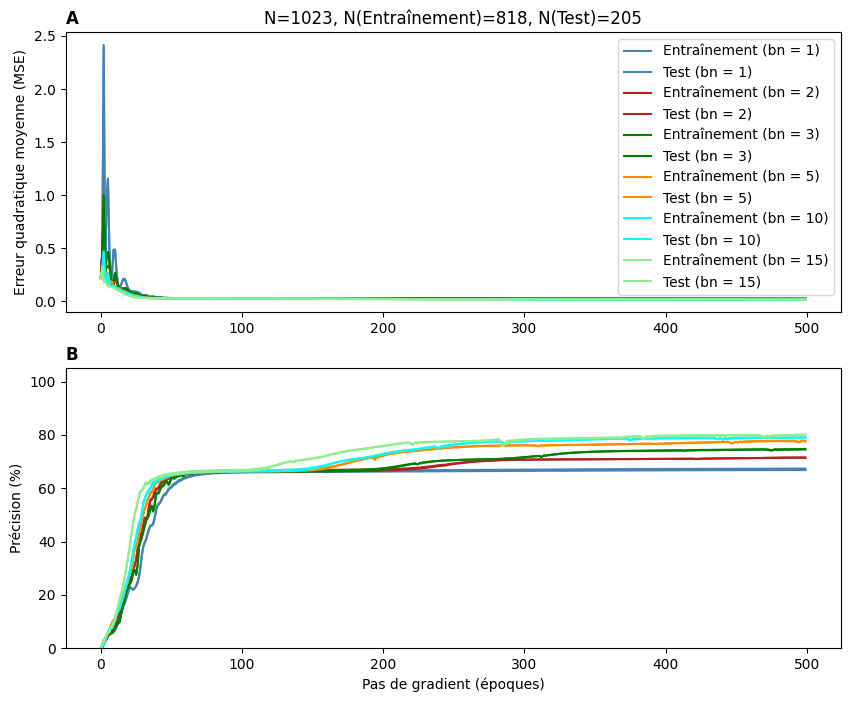

In [20]:
colors = [["steelblue", "steelblue"], 
          ["firebrick", "firebrick"], 
          ["green", "green"],
          ["darkorange", "darkorange"], 
          ["aqua", "aqua"], 
          ["lightgreen", "lightgreen"]]

info_exp = ["bn = 1", "bn = 2", "bn = 3", "bn = 5", "bn = 10", "bn = 15"]
title = f"N={brca_data.shape[1]}, N(Entraînement)={X_train.shape[0]}, N(Test)={X_test.shape[0]}"
plot_multiple_learning_curves(6, colors, info_exp, 
                              title,
                              tests_bn_vae)

In [ ]:

tests_bn_vae = []
bn_try = [20,25,30,50,75]
for bn_size in bn_try :
    vae = VariationalAutoencoder(insize, bn_size, 200)
    trainMSE_bn_vae, testMSE_bn_vae, trainCorr_bn_vae, testCorr_bn_vae = train_Variational_Autoencodeur(vae, X_train, X_test, 500, 100, 0.0001, 0.001)
    tests_bn_vae.append([trainMSE_bn_vae, testMSE_bn_vae, [i * 100 for i in trainCorr_bn_vae], [i * 100 for i in testCorr_bn_vae]])

    bn_precision_vae.append(testCorr_bn_vae[-1]*100)
    bn_size_test_vae.append(bn_size)

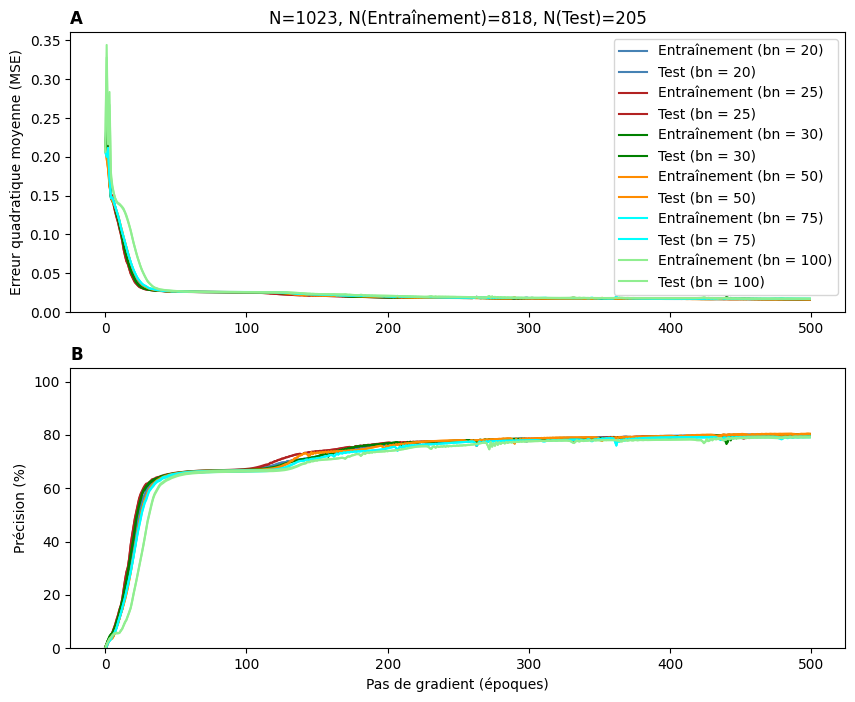

In [18]:
colors = [["steelblue", "steelblue"], 
          ["firebrick", "firebrick"], 
          ["green", "green"],
          ["darkorange", "darkorange"], 
          ["aqua", "aqua"], 
          ["lightgreen", "lightgreen"]]

info_exp = ["bn = 20", "bn = 25", "bn = 30", "bn = 50", "bn = 75", "bn = 100"]
title = f"N={brca_data.shape[1]}, N(Entraînement)={X_train.shape[0]}, N(Test)={X_test.shape[0]}"
plot_multiple_learning_curves(5, colors, info_exp, 
                              title,
                              tests_bn_vae)

In [ ]:
tests_bn_vae = []
bn_try = [125,150,200,300]
for bn_size in bn_try :
    vae = VariationalAutoencoder(insize, bn_size, 200)
    trainMSE_bn_vae, testMSE_bn_vae, trainCorr_bn_vae, testCorr_bn_vae = train_Variational_Autoencodeur(vae, X_train, X_test, 500, 100, 0.0001, 0.001)
    tests_bn_vae.append([trainMSE_bn_vae, testMSE_bn_vae, [i * 100 for i in trainCorr_bn_vae], [i * 100 for i in testCorr_bn_vae]])

    bn_precision_vae.append(testCorr_bn_vae[-1]*100)
    bn_size_test_vae.append(bn_size)

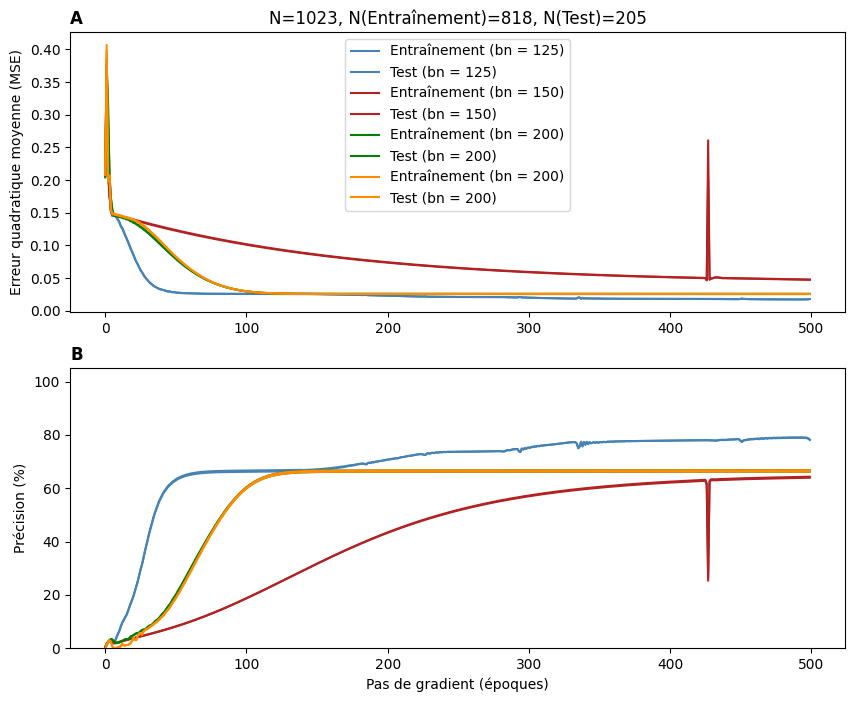

In [22]:
colors = [["steelblue", "steelblue"], 
          ["firebrick", "firebrick"], 
          ["green", "green"],
          ["darkorange", "darkorange"], 
          ["aqua", "aqua"], 
          ["lightgreen", "lightgreen"]]

info_exp = ["bn = 125", "bn = 150", "bn = 200", "bn = 200", "bn = 75", "bn = 100"]
title = f"N={brca_data.shape[1]}, N(Entraînement)={X_train.shape[0]}, N(Test)={X_test.shape[0]}"
plot_multiple_learning_curves(4, colors, info_exp, 
                              title,
                              tests_bn_vae)

In [86]:
print(bn_size_test_vae)
print(bn_precision_vae)

[1, 2, 3, 5, 10, 15, 20, 25, 30, 50, 75, 125, 150, 200, 300]
[67.16361180040302, 71.41422258656901, 74.89750976055961, 78.31734403176391, 79.65440531588298, 79.75654527895547, 79.77178697809777, 79.81444351750831, 80.00746289351021, 80.18812834191685, 79.12929715477799, 79.27597302967267, 78.09745421723278, 77.97724617230332, 78.42398575269142]


In [24]:
bn_vae_to_plot = {}
for i in range(len(bn_size_test_vae)) : bn_vae_to_plot[str(bn_size_test_vae[i])] = np.round(bn_precision_vae[i],1)

[Text(-45, 0, '67.2%'),
 Text(-45, 0, '71.4%'),
 Text(-45, 0, '74.9%'),
 Text(-45, 0, '78.3%'),
 Text(-45, 0, '79.7%'),
 Text(-45, 0, '79.8%'),
 Text(-45, 0, '79.8%'),
 Text(-45, 0, '79.8%'),
 Text(-45, 0, '80.0%'),
 Text(-45, 0, '80.2%'),
 Text(-45, 0, '79.1%'),
 Text(-45, 0, '79.3%'),
 Text(-45, 0, '78.1%'),
 Text(-45, 0, '78.0%'),
 Text(-45, 0, '78.4%')]

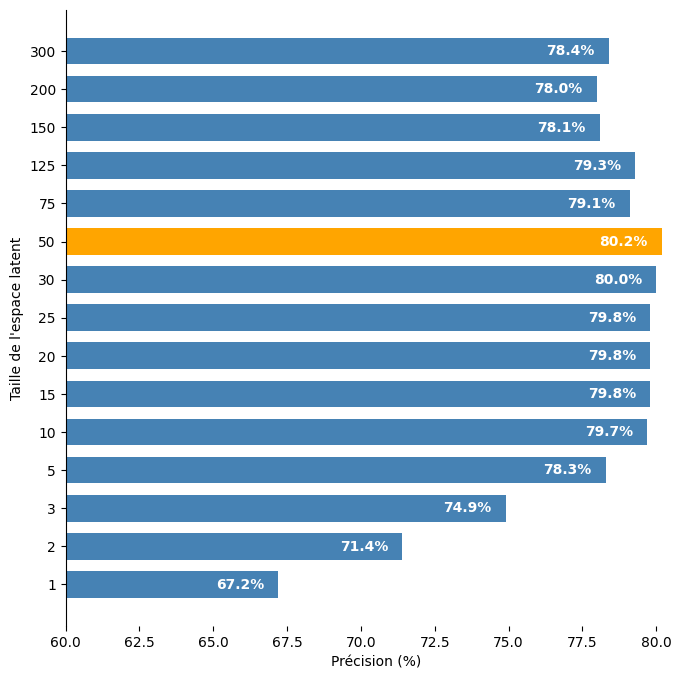

In [25]:
df = pd.DataFrame(bn_vae_to_plot.items(), columns=["bn_size", "precision"])
highest_precision = max(np.round(bn_precision_vae,1))
df["colors"] = df["precision"].apply(lambda x: "orange" if x == highest_precision else "steelblue")

fig, ax = plt.subplots(figsize=(8,8))
bars = plt.barh(df["bn_size"], df["precision"], height=0.7, color=df["colors"])

ax.spines[["right", "top", "bottom"]].set_visible(False)
plt.ylabel("Taille de l'espace latent", fontsize=10)
plt.xlabel("Précision (%)", fontsize=10)
plt.xlim(60,81)

ax.bar_label(bars, padding = -45, color = "white", fontsize=10, label_type="edge", fmt="%.1f%%", fontweight="bold")

Epoch 0 --- Train Error : 0.21 ~ Test Error : 0.22 ~ Train Acc : -0.0 ~ Test Acc : -0.0 
Epoch 100 --- Train Error : 0.03 ~ Test Error : 0.03 ~ Train Acc : 0.66 ~ Test Acc : 0.66 
Epoch 200 --- Train Error : 0.02 ~ Test Error : 0.02 ~ Train Acc : 0.76 ~ Test Acc : 0.77 
Epoch 300 --- Train Error : 0.02 ~ Test Error : 0.02 ~ Train Acc : 0.79 ~ Test Acc : 0.79 
Epoch 400 --- Train Error : 0.02 ~ Test Error : 0.02 ~ Train Acc : 0.8 ~ Test Acc : 0.8 


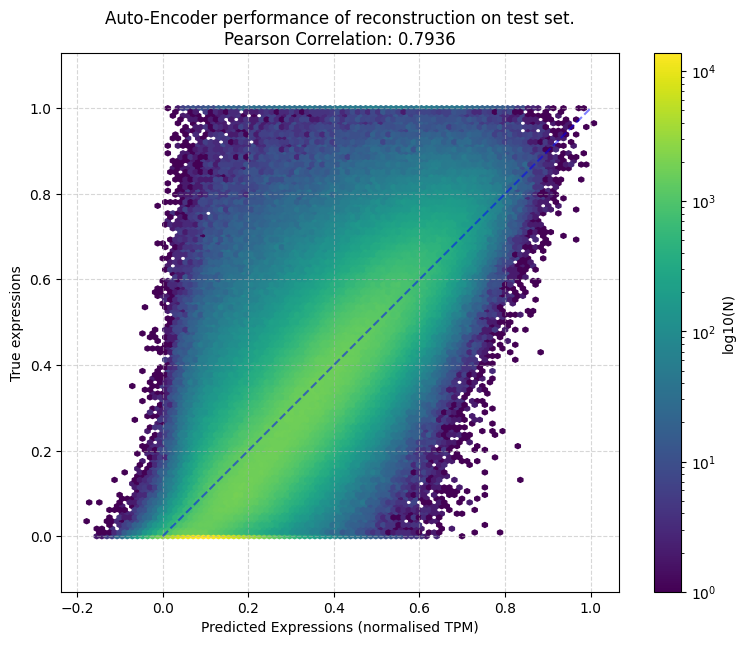

In [18]:
# Affichage de la heatmap du vae le plus précis
vae = VariationalAutoencoder(insize, 50, 200)
trainMSE_bn_vae, testMSE_bn_vae, trainCorr_bn_vae, testCorr_bn_vae = train_Variational_Autoencodeur(vae, X_train, X_test, 500, 100, 0.0001, 0.001)

plot_ae_performance(vae, X_test)

Quels sont les paramètres idéaux? Quelle est la taille de bottleneck idéale? Quels sont les paramètres sensibles? Qu'en concluez-vous?

Les analyses sur le bottleneck sont précisés dans le pdf du projet. 

Analyse sommaire des autres hyper-paramètres étudiés: 

À première vue, les hyper-paramètres sensibles pour la vitesse d'apprentissage semblent être le learning rate, et la taille de la couche interne. En effet,ces deux paramètres impactent peu la convergence du modèle vers une certaine précision, mais impacte grandement la vitesse d'atteinte de ce point de convergence. Ces hyper-paramètres sont donc à considérer si le nombre d'épochs doit être minimisé. 

Les hyper-paramètres sensibles à la précision sont weight decay. En effet, celui-ci semble impacter directement la précision vers lequel le modèle converge beaucoup plus fortement que les autres hyper-paramètres étudiés. 

De plus, ces observations semblent être constante entre les deux modèles (AE, AEV). Les paramètres finaux sont précisés plus bas.

En conclusion, le choix des valeurs de ces hyper-paramètres à un impact à la fois sur la vitesse d'apprentissage et la précision finale des modèles. Le paramètres ayant le plus d'importance dépend de ce que l'on cherche à optimiser.

<u> Paramètres finaux </u>

1. Autoencodeur (AE)
    - Couches internes = 400 neurones
    - Weight Decay = 0.0001
    - Learning Rate = 0.001
    - Bottleneck Size = 10

2. Autoencodeur variationel (VAE)
    - Couches internes = 200 neurones
    - Weight Decay = 0.0001
    - Learning Rate = 0.001
    - Bottleneck Size = 50

#### Partie 2 du projet: Quelles est la meilleur approche à utiliser entre AE, VAE et UMAP non-supervisé pour les 4 jeux de données étudiés ?

Note: Pour la description de chacun des jeux de données utilisés: Voir le pdf avec les résultats

Note: Pour voir les résultats, voir le pdf du projet

In [39]:
def ae_compare(insize, outsize, X_train, X_test):
    ae_bn, en_bn = buildModel(insize, outsize, 400, 2)
    trainMSE_bn, testMSE_bn, trainCorr_bn, testCorr_bn = trainModel(ae_bn, X_train, X_test, 500, 0.001, 0.0001)
    return en_bn

def vae_compare(insize, X_train, X_test):
    vae = VariationalAutoencoder(insize, 2, 200)
    trainMSE_bn_vae, testMSE_bn_vae, trainCorr_bn_vae, testCorr_bn_vae = train_Variational_Autoencodeur(vae, X_train, X_test, 500, 100, 0.0001, 0.001)
    return vae

1. Comparaison BRCA

Note: Le jeu d'entraînement et de test utilisé correspond à celui de UMAP dans la partie présentation des données

In [ ]:
# AE
en_bn = ae_compare(insize, outsize, torch.Tensor(X_train_br), torch.Tensor(X_test_br))

In [ ]:
# Visualisation 2D
enc_test = en_bn(torch.Tensor(X_test_br))
enc_train = en_bn(torch.Tensor(X_train_br))

enc_test_df = pd.DataFrame(enc_test.detach().numpy())
enc_train_df = pd.DataFrame(enc_train.detach().numpy())

# Le code couleur est le même que pour UMAP
plotAE_2D(targets_br, colors_br, enc_train_df, enc_test_df, Y_test_br, Y_train_br)

In [ ]:
# VAE
vae = vae_compare(insize, torch.Tensor(X_train_br), torch.Tensor(X_test_br))

In [ ]:
# Visualisation 2D
enc_test_br_vae = vae.encoder(torch.Tensor(X_test_br))
enc_train_br_vae = vae.encoder(torch.Tensor(X_train_br))

enc_test_df_br_vae = pd.DataFrame(enc_test_br_vae.detach().numpy())
enc_train_df_br_vae = pd.DataFrame(enc_train_br_vae.detach().numpy())

plotAE_2D(targets_br, colors_br, enc_train_df_br_vae, enc_test_df_br_vae, Y_test_br, Y_train_br)

In [ ]:
# UMAP
# Le code et les résultats sont directement repris de la partie sur la présentation des données 

2. Comparaison avec TCGA

In [ ]:
# AE
en_bn_tc = ae_compare(X_train_tc.shape[1], X_train_tc.shape[1], torch.Tensor(X_train_tc), torch.Tensor(X_test_tc))

In [ ]:
enc_test_tc = en_bn_tc(torch.Tensor(X_test_tc))
enc_train_tc = en_bn_tc(torch.Tensor(X_train_tc))

enc_test_df_tc = pd.DataFrame(enc_test_tc.detach().numpy())
enc_train_df_tc = pd.DataFrame(enc_train_tc.detach().numpy())

plotAE_2D(targets_tc, colors_tc, enc_train_df_tc, enc_test_df_tc, Y_test_tc, Y_train_tc)

In [ ]:
# VAE
vae_tc = vae_compare(X_train_tc.shape[1], torch.Tensor(X_train_tc), torch.Tensor(X_test_tc))

enc_test_tc_vae = vae_tc.encoder(torch.Tensor(X_test_tc))
enc_train_tc_vae = vae_tc.encoder(torch.Tensor(X_train_tc))

enc_test_df_tc_vae = pd.DataFrame(enc_test_tc_vae.detach().numpy())
enc_train_df_tc_vae = pd.DataFrame(enc_train_tc_vae.detach().numpy())

plotAE_2D(targets_tc, colors_tc, enc_train_df_tc_vae, enc_test_df_tc_vae, Y_test_tc, Y_train_tc)

3. Comparaison avec AML

In [ ]:
# AE
en_bn_aml = ae_compare(X_train_la.shape[1], X_train_la.shape[1], torch.Tensor(X_train_la), torch.Tensor(X_test_la))

enc_test_aml = en_bn_aml(torch.Tensor(X_test_la))
enc_train_aml = en_bn_aml(torch.Tensor(X_train_la))

enc_test_df_aml = pd.DataFrame(enc_test_aml.detach().numpy())
enc_train_df_aml = pd.DataFrame(enc_train_aml.detach().numpy())

plotAE_2D(targets_la, colors_la, enc_train_df_aml, enc_test_df_aml, Y_test_la, Y_train_la)

In [ ]:
plotAE_2D(targets_la, colors_la, enc_train_df_aml, enc_test_df_aml, Y_test_la, Y_train_la)

In [ ]:
# VAE
vae_aml = vae_compare(X_train_la.shape[1], torch.Tensor(X_train_la), torch.Tensor(X_test_la))

enc_test_aml_vae = vae_aml.encoder(torch.Tensor(X_test_la))
enc_train_aml_vae = vae_aml.encoder(torch.Tensor(X_train_la))

enc_test_df_aml_vae = pd.DataFrame(enc_test_aml_vae.detach().numpy())
enc_train_df_aml_vae = pd.DataFrame(enc_train_aml_vae.detach().numpy())



In [ ]:
plotAE_2D(targets_la, colors_la, enc_train_df_aml_vae, enc_test_df_aml_vae, Y_test_la, Y_train_la)

4. Comparaison avec TALL

In [ ]:
# AE
en_bn_tall = ae_compare(X_train_ta.shape[1], X_train_ta.shape[1], torch.Tensor(X_train_ta), torch.Tensor(X_test_ta))

enc_test_tall = en_bn_tall(torch.Tensor(X_test_ta))
enc_train_tall = en_bn_tall(torch.Tensor(X_train_ta))

enc_test_df_tall = pd.DataFrame(enc_test_tall.detach().numpy())
enc_train_df_tall = pd.DataFrame(enc_train_tall.detach().numpy())


In [ ]:
plotAE_2D(targets_ta, colors_ta, enc_train_df_tall, enc_test_df_tall, Y_test_ta, Y_train_ta)

In [ ]:
vae_tall = vae_compare(X_train_ta.shape[1], torch.Tensor(X_train_ta), torch.Tensor(X_test_ta))

enc_test_tall_vae = vae_tall.encoder(torch.Tensor(X_test_ta))
enc_train_tall_vae = vae_tall.encoder(torch.Tensor(X_train_ta))

enc_test_df_tall_vae = pd.DataFrame(enc_test_tall_vae.detach().numpy())
enc_train_df_tall_vae = pd.DataFrame(enc_train_tall_vae.detach().numpy())

plotAE_2D(targets_ta, colors_ta, enc_train_df_tall_vae, enc_test_df_tall_vae, Y_test_ta, Y_train_ta)